In [169]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py


from astropy    import units as u
from matplotlib import pyplot as plt

from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

from common import hallmark as hm
from common import mockservation as mk
from common import io_raptor as io
from common import dalt
from common import viz

import rapplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test IO

In [170]:
# output/RAPTOR_230GHz/{mag}a{aspin:g}_w{window:d}/Rh_{Rhigh:d}_i{inc:d}/img_data_{snapshot:d}.h5

pf = hm.ParaFrame('cache/{mag}a{aspin:g}_w{window:d}/Rh{Rhigh:d}_i{inc:d}/img_data_{snapshot:d}.h5')


In [171]:
sel = pf(inc=45)
display(sel)

,path,mag,aspin,window,Rhigh,inc,snapshot
0,cache/Ma101_w1/Rh1_i45/img_data_100.h5,M,101.0,1,1,45,100
1,cache/Ma101_w1/Rh1_i45/img_data_101.h5,M,101.0,1,1,45,101


In [172]:
# TODO do io.load_img(sel.path)
# img = io.load_img('output/plot/Ma101_w1/Rh1_i60/img_data_1.h5', pf(path = 'output/plot/Ma101_w1/Rh1_i60/img_data_1.h5').snapshot)
# meta = img.meta

In [173]:
#TODO: units match

# fig, ax = plt.subplots(1, 1)
# ax.imshow(img)
# fig.show()

# ax = viz.show(img, s=0)

path.iloc : 
 
 https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html 

In [174]:
# print(sel.snapshot)
# print(np.array(sel.snapshot))

In [175]:
snaps = np.array(sel.snapshot)
mov = io.load_mov(sel.path.iloc[0], snaps)
print(mov.shape)
# viz.show(mov, s=0)

(1, 10, 10)


In [176]:
display(meta.mass, meta.dist, meta.freq)
display(meta.time, meta.width, meta.height)

<Quantity 4140000. solMass>

<Quantity 8127. pc>

<Quantity 230. GHz>

<Quantity 10. M>

<Quantity 10. M>

<Quantity 10. M>

In [177]:
display(meta.width.to(u.uas, meta.geom),
        meta.height.to(u.uas, meta.geom))

<Quantity 50.28227252 uas>

<Quantity 50.28227252 uas>

In [179]:
print(mov)

[[[3.51666443e-14 3.40071274e-14 3.16088992e-14 2.82364878e-14
   2.45555229e-14 2.10269518e-14 1.77139967e-14 1.47311377e-14
   1.20767107e-14 9.69118967e-15]
  [3.29797292e-14 3.10169691e-14 2.78896915e-14 2.43050567e-14
   2.08736419e-14 1.77031475e-14 1.47639815e-14 1.21419364e-14
   9.78112421e-15 7.68907768e-15]
  [3.02119878e-14 2.74389395e-14 2.41379374e-14 2.07314619e-14
   1.76015749e-14 1.47523522e-14 1.22017348e-14 9.89199010e-15
   7.81730730e-15 6.01020405e-15]
  [2.69480915e-14 2.37795015e-14 2.05689444e-14 1.75305554e-14
   1.47401223e-14 1.22092004e-14 9.96207502e-15 7.94041770e-15
   6.14068698e-15 4.63770671e-15]
  [2.34438686e-14 2.02947747e-14 1.74112717e-14 1.47033247e-14
   1.22284275e-14 9.99835252e-15 8.02263708e-15 6.24839475e-15
   4.75735593e-15 3.54656238e-15]
  [2.01021076e-14 1.72342418e-14 1.45983002e-14 1.22058052e-14
   1.00509286e-14 8.10189011e-15 6.34344489e-15 4.84809200e-15
   3.63936437e-15 2.66895733e-15]
  [1.70627257e-14 1.45081210e-14 1.21529

## Test va

<Axes: xlabel='u [G$\\lambda$]', ylabel='v [G$\\lambda$]'>

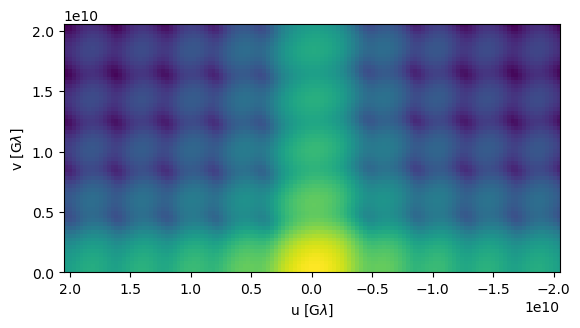

In [180]:
vis = mk.mockserve(mov, N=128)
viz.show(vis, s=0, f=lambda v: np.log(abs(v).value))

RegularGridInterpolator Scipy:  
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html 

In [183]:
U, V = vis.uvd

u = np.linspace( 0,   U/2, num=vis.shape[-1])
v = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
t = vis.meta.time.value

# print(u.shape)
# print(v.shape)
# print(t)
# print(abs( vis[...,::-1]) )

amp = RegularGridInterpolator((t, v, u[::-1]), abs     (vis[...,::-1]))
phi = RegularGridInterpolator((t, v, u[::-1]), np.angle(vis[...,::-1]))

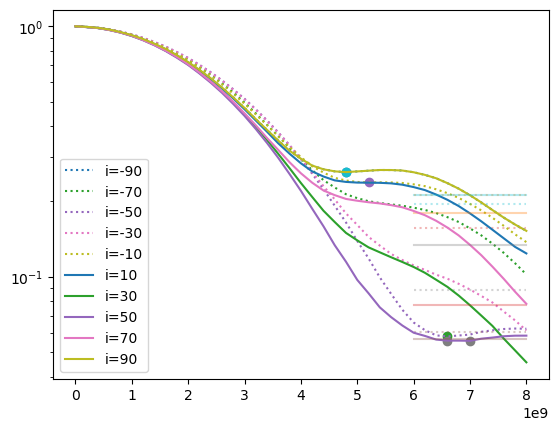

In [188]:
bmin = 6e9
bmax = 8e9

uvd = np.linspace(0, bmax, round(bmax/2e8)+1)

for i in range(-90,90+1,20):
    phi = np.pi * i / 180

    u = uvd * np.cos(phi)
    v = uvd * np.sin(phi)

    mask = u <= 0
    
    p = np.array([np.repeat(t[0], np.sum( mask)),  v[ mask],  u[ mask]]).T
    m = np.array([np.repeat(t[0], np.sum(~mask)), -v[~mask], -u[~mask]]).T
    
    s = np.zeros(len(uvd))
    s[ mask] = amp(p)
    s[~mask] = amp(m)
        
    plt.semilogy(uvd, s/s[0], ':' if i < 0 else '-', label=f'i={i}')

    lm = argrelextrema(s, np.less)[0]
    plt.scatter(uvd[lm], s[lm]/s[0])
    
    ms = np.median(s[(bmin < uvd) & (uvd < bmax)]) / s[0]
    plt.plot([bmin, bmax], [ms, ms], ':' if i < 0 else '-', alpha=1/3)

plt.legend()